In [1095]:
import cv2
# to install cv2 use: pip install opencv-python
import matplotlib.pyplot as plt 
import numpy as np

Image shape: (400, 600)
(400, 600)


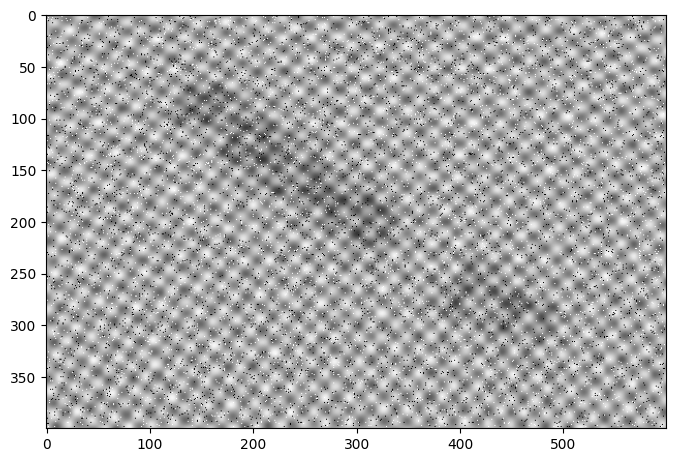

In [1096]:
fname = 'Letters-noisy.png'
img = cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
H, W = img.shape
# Print the image shape
print(f"Image shape: {img.shape}")
print(img.shape)
ratio=W/H
fig = plt.figure(figsize=(8,8*ratio))
plt.imshow(img, cmap='gray')

In [1097]:
def rescale (image):
    image = np.absolute(image)
    mymin=np.amin(image)
    mymax=np.amax(image)
    W = image.shape[0]
    H = image.shape[1]
    #for y in range(H): 
    #    for x in range(W): 
    #        image[x,y] = (image[x,y]-mymin)*255/(mymax-mymin)
    scale = 255/(mymax-mymin)
    image = (image-mymin)* scale
    image = np.ndarray.astype(image, dtype=np.uint8, copy=True)
    return image

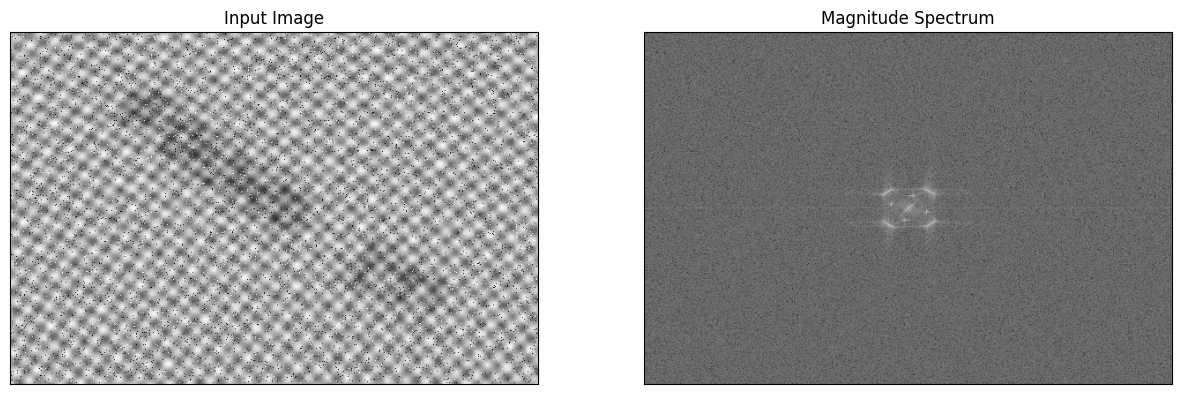

In [1098]:
# convert the image representation to SPFP
img_float32 = np.float32(img)

# compute the DFT
# Note that the computed DFT has 2 channels :
# dft[:,:,0] - real values
# dft[:,:,1] - imaginary values
dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
# recenter the DFT , such that the center is (0,0)
dft_shift = np.fft.fftshift(dft)
# compute the frequency spectrum
# module of the complex value
magnitude_spectrum = cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
magnitude_spectrum = 20*np.log(magnitude_spectrum)


# display the image and the spectrum
fig = plt.figure(figsize=(15,5))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

NOTCH


In [1099]:
# shape: (W,H) are the width and height of the filter

# d0 is the radius of the filter expressed in pixels

# u_k and v_k are the center coordinates in the Fourier image plane for the notch filter
# u_k=0, v_k=0 correspond to the center of the shifted spectrum

def notch_reject_filter_vec(shape: tuple[int, int], d0: int, u_k: int, v_k: int):
    (W, H) = shape

    H_0_u = np.repeat(np.arange(W), H).reshape((W, H))
    H_0_v = np.repeat(np.arange(H), W).reshape((H, W)).transpose()

    D_uv = np.sqrt((H_0_u - W / 2 + u_k) ** 2 + (H_0_v - H / 2 + v_k) ** 2)
    D_muv = np.sqrt((H_0_u - W / 2 - u_k) ** 2 + (H_0_v - H / 2 - v_k) ** 2)

    selector_1 = D_uv <= d0
    selector_2 = D_muv <= d0

    selector = np.logical_or(selector_1, selector_2)

    H = np.ones((W, H, 2), np.uint8)
    H[selector] = 0

    return H

In [1100]:
rows, cols = img.shape

# several notch filters can be composited by multiplication

# fill in the following lists to compose multiple notch filters
d0_list = [10, 10] + [7, 8]
u_k_list = [18, 18] + [ 0, 18]
v_k_list = [25, -23] + [ 18, -2]

H = notch_reject_filter_vec (img.shape, d0_list[0], u_k_list[0], v_k_list[0])

for d0, u_k, v_k in zip (d0_list[1:], u_k_list[1:], v_k_list[1:]):
    Haux = notch_reject_filter_vec (img.shape, d0, u_k, v_k)

    H *= Haux
    
# apply mask and inverse DFT
dft_masked = dft_shift*H
# do not forget to undo the centering of the transform
dft_masked_ishift = np.fft.ifftshift(dft_masked)
img_notch = cv2.idft(dft_masked_ishift)

# img_notch should only have real values
# but let's make sure due to rounding and representation errors
img_notch = cv2.magnitude(img_notch[:,:,0],img_notch[:,:,1])
#normalize
cv2.normalize(img_notch, img_notch, 0, 1, cv2.NORM_MINMAX)


array([[0.6437831 , 0.4215653 , 0.43979478, ..., 0.44048664, 0.43688285,
        0.44572857],
       [0.6492775 , 0.44792107, 0.4612758 , ..., 0.49234325, 0.48522007,
        0.48266035],
       [0.6612479 , 0.4706367 , 0.48107317, ..., 0.5386308 , 0.5270654 ,
        0.5120847 ],
       ...,
       [0.62393165, 0.56033754, 0.57507056, ..., 0.5515021 , 0.5327778 ,
        0.5149513 ],
       [0.62883455, 0.5749113 , 0.7671489 , ..., 0.52873206, 0.5159343 ,
        0.5033505 ],
       [0.6336724 , 0.59109306, 0.6037969 , ..., 0.5007539 , 0.5001414 ,
        0.49251342]], shape=(400, 600), dtype=float32)

In [1101]:
# compute the DFT of the processed image (img_back)
# Note that the computed DFT has 2 channels :
# dft[:,:,0] - real values
# dft[:,:,1] - imaginary values

rows, cols = img_notch.shape
# dft_proc = cv2.dft(img_notch, flags = cv2.DFT_COMPLEX_OUTPUT)
# # recenter the DFT , such that the center is (0,0)
dft = cv2.dft(img_notch, flags = cv2.DFT_COMPLEX_OUTPUT)
dft_proc_shift = np.fft.fftshift(dft)
# compute the frequency spectrum
# module of the complex value
filtered_spectrum = cv2.magnitude(dft_proc_shift[:,:,0],dft_proc_shift[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
filtered_spectrum = 20*np.log(filtered_spectrum+0.0001)

In [1102]:
# compute the frequency spectrum of the MASK, 
# just for display purposes
# module of the complex value
mask_spectrum = np.sqrt(np.power(H[:,:,0],2)+np.power(H[:,:,1],2))
# compute the logarith of magnitude such that smaller values are visible
mask_spectrum = 20*np.log(mask_spectrum+0.0001)

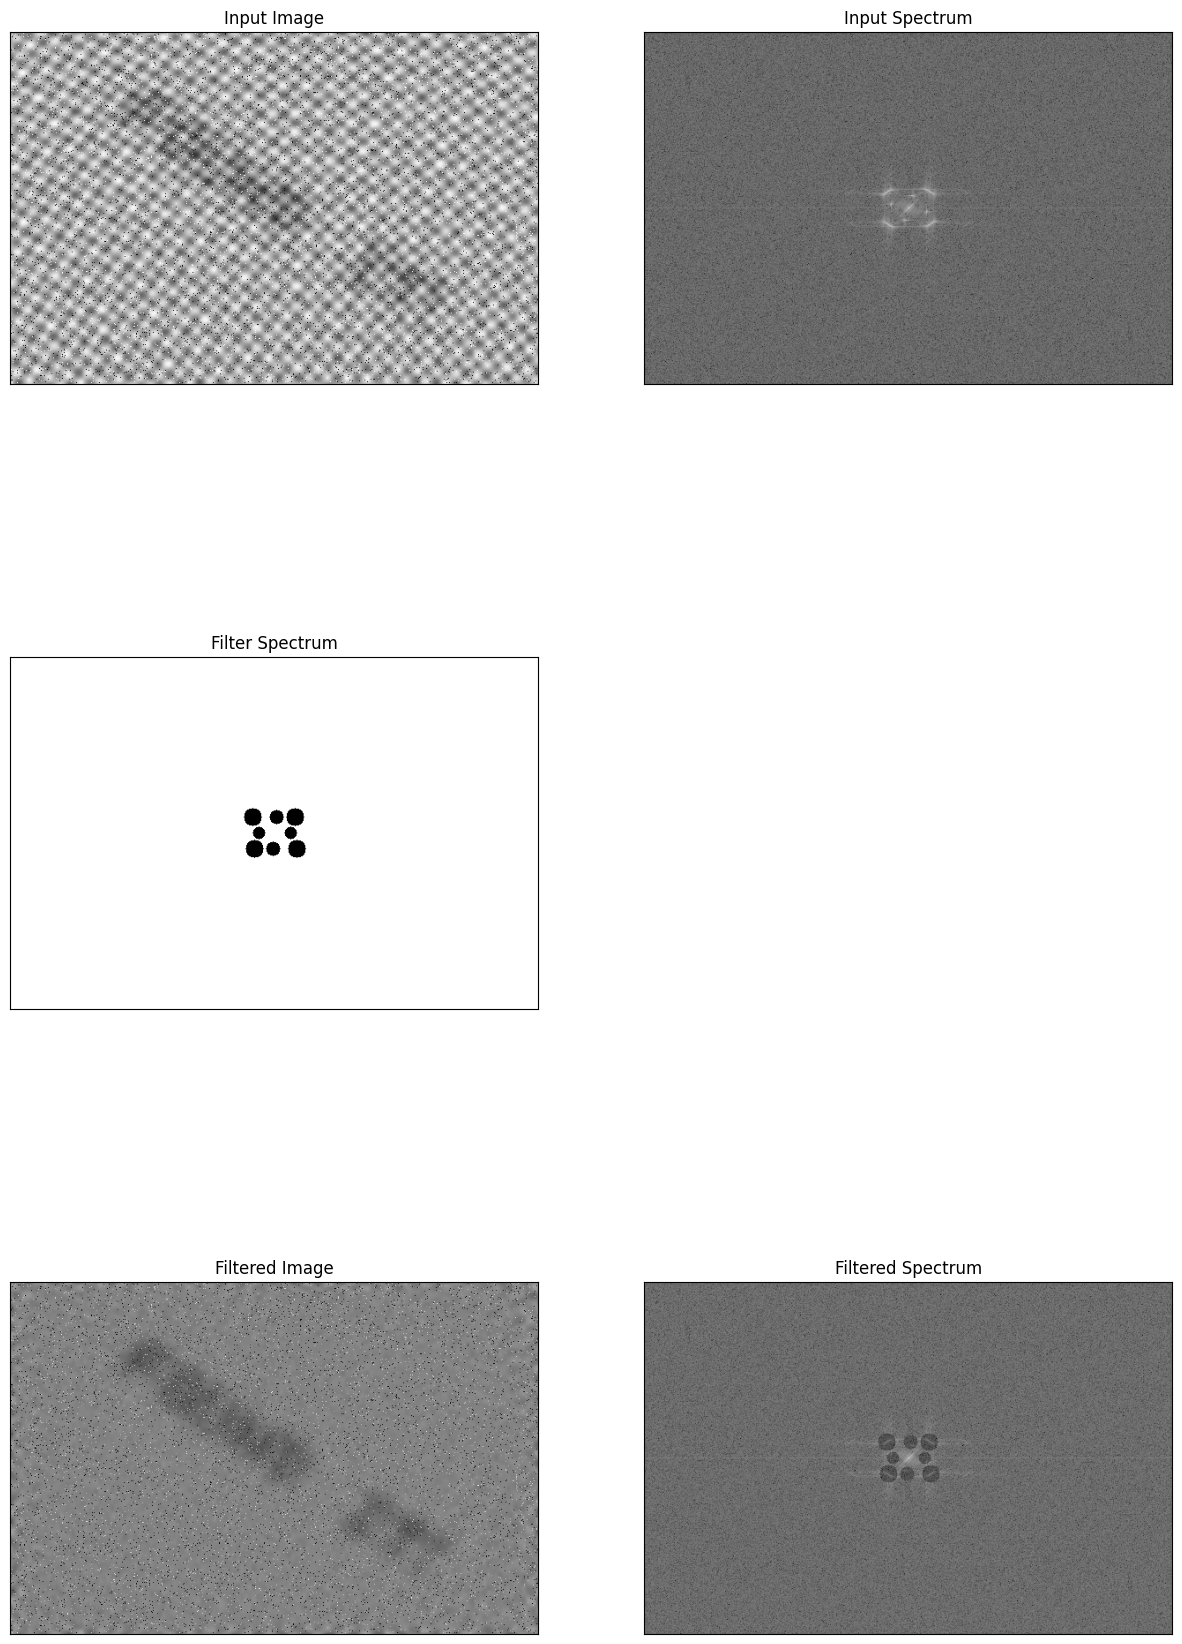

In [1103]:
# display the image and the spectrum
fig = plt.figure(figsize=(15,23))
plt.subplot(321),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(322),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Input Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(323),plt.imshow(mask_spectrum, cmap = 'gray')
plt.title('Filter Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(325),plt.imshow(img_notch, cmap = 'gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(326),plt.imshow(filtered_spectrum, cmap = 'gray')
plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])
plt.show() 

In [1104]:
# manually filter high frequencies using our own ILPF
rows, cols = img_notch.shape
crow, ccol = rows//2 , cols//2     # center

# create a mask first, center square is 1, remaining all zeros
ILPF_mask = np.zeros((rows, cols, 2), np.uint8)
# filter width and heigth
divider = 16
frows = rows//divider
fcols = cols//divider
ILPF_mask[crow-frows:crow+frows, ccol-fcols:ccol+fcols] = (1,1)
#ILPF_mask[crow-30:crow+30, ccol-30:ccol+30] = 1

dft_shift = dft_proc_shift
# compute the frequency spectrum
# module of the complex value
magnitude_spectrum = cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
magnitude_spectrum = 20*np.log(magnitude_spectrum)

# apply mask and inverse DFT
dft_masked = dft_shift*ILPF_mask
# do not forget to undo the centering of the transform
dft_masked_ishift = np.fft.ifftshift(dft_masked)
img_back = cv2.idft(dft_masked_ishift)

# img_back should only have real values
# but let's make sure due to rounding and representation errors
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

img_back = cv2.normalize(img_back, None, 0, 1, cv2.NORM_MINMAX)


In [1105]:
dft_proc = cv2.dft(img_back, flags = cv2.DFT_COMPLEX_OUTPUT)
# # recenter the DFT , such that the center is (0,0)
dft_proc_shift = np.fft.fftshift(dft_proc)
filtered_spectrum = cv2.magnitude(dft_proc_shift[:,:,0],dft_proc_shift[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
filtered_spectrum = 20*np.log(filtered_spectrum+0.0001)
# compute the frequency spectrum of the MASK, 
# just for display purposes
# module of the complex value
mask_spectrum = np.sqrt(np.power(ILPF_mask[:,:,0],2)+np.power(ILPF_mask[:,:,1],2))
# compute the logarith of magnitude such that smaller values are visible
mask_spectrum = 20*np.log(mask_spectrum+0.0001)

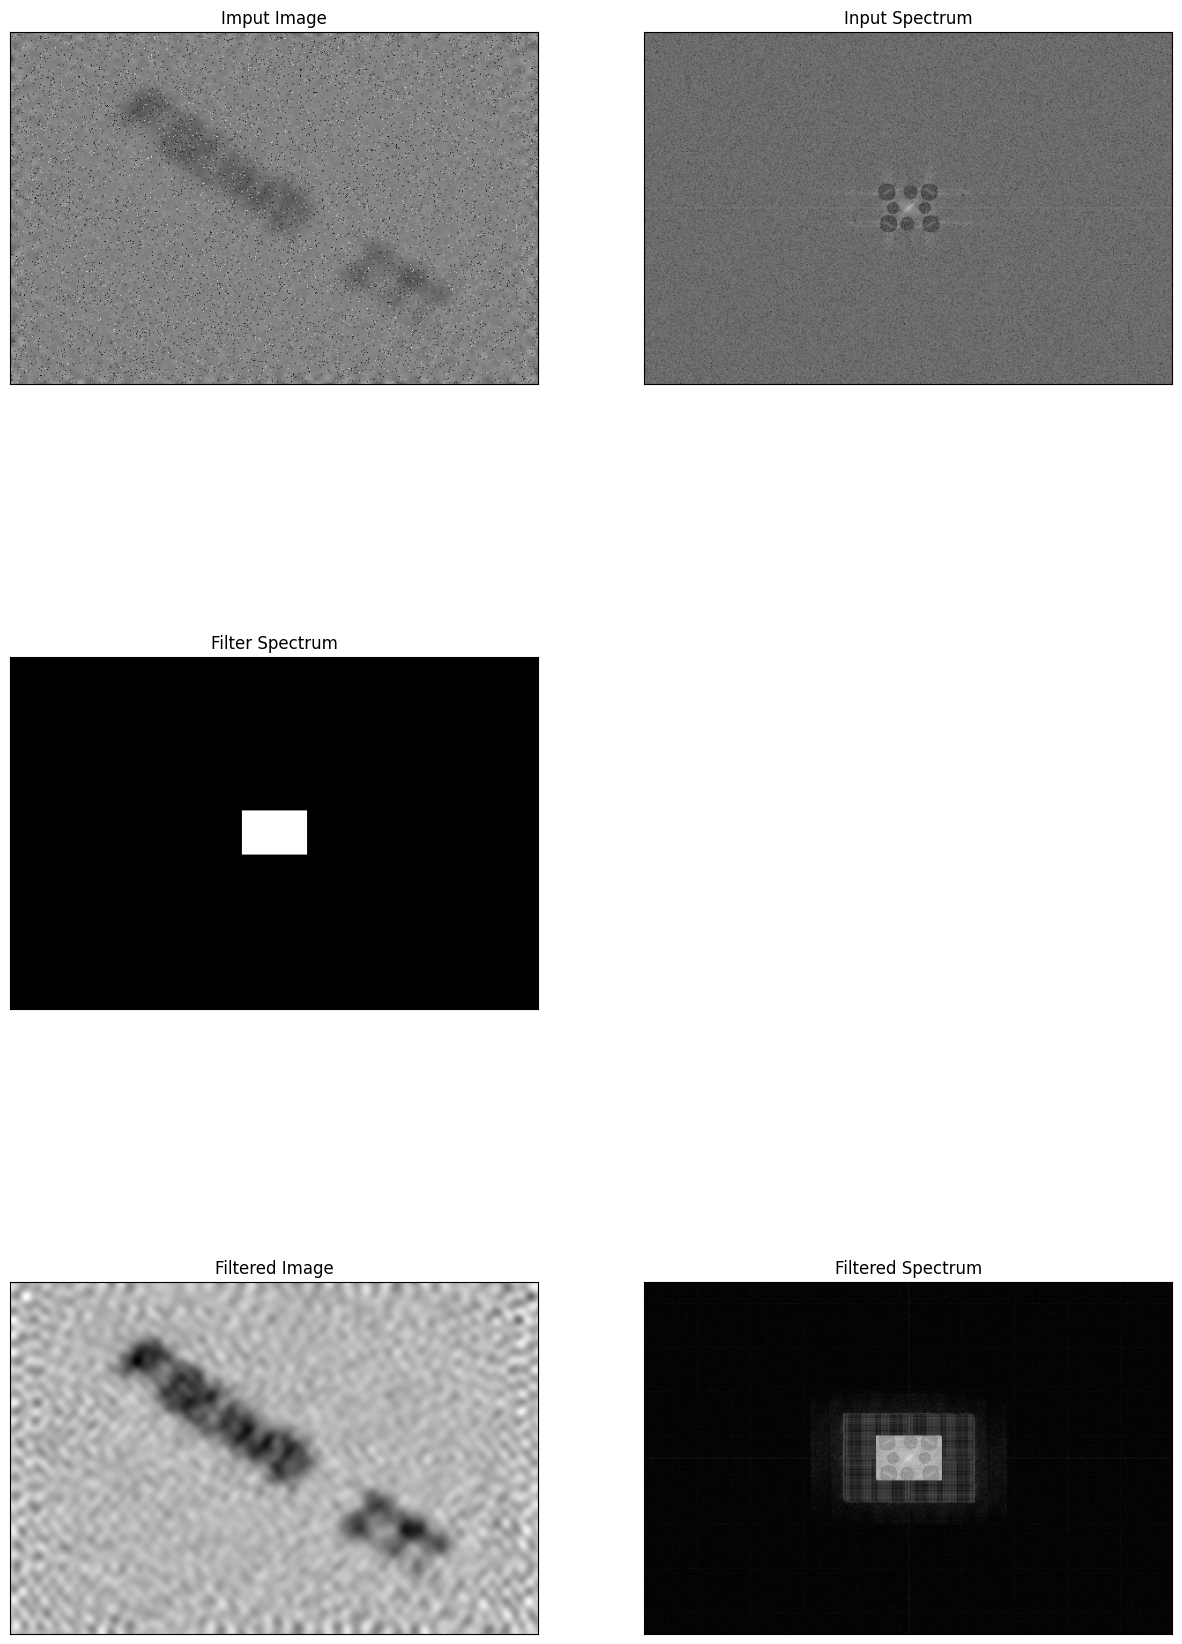

In [1106]:
# display the image and the spectrum
fig = plt.figure(figsize=(15,23))
plt.subplot(321),plt.imshow(img_notch, cmap = 'gray')
plt.title('Imput Image'), plt.xticks([]), plt.yticks([])
plt.subplot(322),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Input Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(323),plt.imshow(mask_spectrum, cmap = 'gray')
plt.title('Filter Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(325),plt.imshow(img_back, cmap = 'gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(326),plt.imshow(filtered_spectrum, cmap = 'gray')
plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

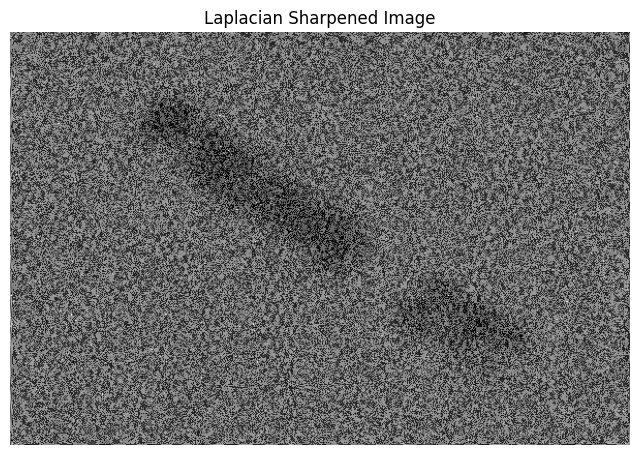

In [1107]:
# Convert the image to uint8 (since Laplacian does not support float32)

# img_notch must be changed to img_back when banding problem is fixed
#img_uint8 = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

img_uint8 = rescale(img_notch)

# Apply Laplacian filtering to detect edges
laplacian = cv2.Laplacian(img_uint8, cv2.CV_64F)

# Normalize for visibility
#laplacian = cv2.normalize(laplacian, None, 0, 255, cv2.NORM_MINMAX)
laplacian = np.uint8(laplacian)

# Add the Laplacian edges to the original image to enhance sharpness
sharpened = cv2.addWeighted(img_uint8, 1.2, laplacian, -0.5, 0)

# Display the result
plt.figure(figsize=(8, 8))
plt.imshow(sharpened, cmap='gray')
plt.title("Laplacian Sharpened Image")
plt.axis('off')
plt.show()

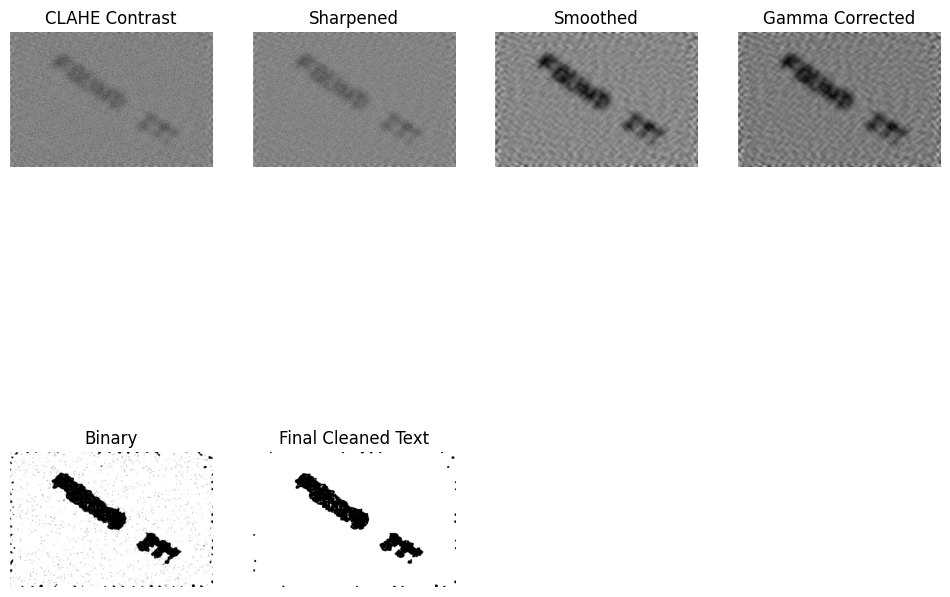

In [ ]:
# Convert image to uint8 (ensures proper processing)
image_uint8 = rescale(img_notch)

# 🔹 Step 1: Apply CLAHE to enhance contrast (before smoothing!)
# clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
# img_contrast = clahe.apply(image_uint8)

# 🔹 Step 2: Apply Unsharp Masking (sharpens edges before thresholding)
gaussian_blur = cv2.GaussianBlur(image_uint8, (5, 5), 1.5)
sharpened = cv2.addWeighted(image_uint8, 2.0, gaussian_blur, -1.0, 0)

# 🔹 Step 3: Apply Bilateral Filtering (softens noise, preserves edges)
smoothed = cv2.bilateralFilter(sharpened, d=9, sigmaColor=100, sigmaSpace=100)

# 🔹 Step 4: Apply Gamma Correction (increase contrast)
# gamma = 1.5  # Reduced gamma for better balance
# img_gamma = np.power(smoothed / 255.0, gamma) * 255
# img_gamma = img_gamma.astype(np.uint8)

# 🔹 Step 5: Apply Otsu's Thresholding
_, binary = cv2.threshold(smoothed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 🔹 Step 6: Use Morphological Operations (removes noise, strengthens edges)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
binary_cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

# 🔹 Visualization
plt.figure(figsize=(12, 10))

plt.subplot(2, 4, 1)
plt.imshow(image_uint8, cmap='gray')
plt.title("CLAHE Contrast")
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(sharpened, cmap='gray')
plt.title("Sharpened")
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(smoothed, cmap='gray')
plt.title("Smoothed")
plt.axis('off')

# plt.subplot(2, 4, 4)
# plt.imshow(img_gamma, cmap='gray')
# plt.title("Gamma Corrected")
# plt.axis('off')

plt.subplot(2, 4, 5)
plt.imshow(binary, cmap='gray')
plt.title("Binary")
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(binary_cleaned, cmap='gray')
plt.title("Final Cleaned Text")
plt.axis('off')

plt.show()


(np.float64(-0.5), np.float64(599.5), np.float64(399.5), np.float64(-0.5))

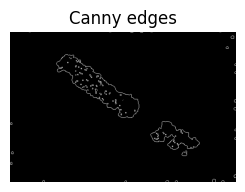

In [1109]:

img_8bit = rescale(binary_cleaned)
# Apply Canny edge detector
edges = cv2.Canny(img_8bit, 100, 200)

plt.subplot(1, 2, 1)
plt.imshow(edges, cmap='gray')
plt.title("Canny edges")
plt.axis('off')